In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', None)
import re
import time
import gc
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import decomposition
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import linear_model, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
current_directory = os.getcwd()
list_csv_files = os.listdir(path= current_directory +'\\data_client_risk')

### Function to evaluate data in a csv file

In [3]:
def columnsDataAvailable(df, perc):
    ''' Creating a Function to evaluate the percentage of data available for each columns and filtering by a chosen % (data deleted under it) which data are kept.
    A bar graph with data kept and their % available would be shown. Data should be a DataFrame and Perc a floating number. It returns a DataFrame filtered.
    Keep in mind that a row is add in the dataSet! The function can only take columns type str!!! It also evaluates the first and last columns with data'''
    valueslast = df.apply(pd.Series.last_valid_index, axis=1)
    valuesfirst = df.apply(pd.Series.first_valid_index, axis=1)

    list_first = [df.columns.get_loc(f) for f in valuesfirst]
    list_last = [df.columns.get_loc(l)for l in valueslast]

    firstcolumns_loc = min(list_first)
    lastcolumns_loc = max(list_last)

    print('columns with first values is {} and columns with last value is {}'.format(
        df.columns[firstcolumns_loc], df.columns[lastcolumns_loc]))

    dataSum = 0
    newData = df.iloc[:, firstcolumns_loc:(lastcolumns_loc+1)]
    percASeries = pd.Series(name='AvailableData %', dtype=float)

    for i in newData.columns:
        dataSum += newData[i].notna().sum()
        percAvailable = (((newData[i].notna().sum())/newData.shape[0])*100)
        if percAvailable < perc:
            newData = newData.drop(i, axis=1)
        else:
            percASeries[i] = percAvailable

        dataSumPerc = (dataSum/(newData.shape[0]*newData.shape[1]))*100

    print('There is {} percent of values available in the Dataframe, available data above {} percent have been kept'.format(dataSumPerc, perc))

    # Bar Graph with the kept data and their percentage
    if int(newData.shape[1]/2) > 20:
        figure1 = plt.figure(figsize=(18, 6))
    else:
        figure1 = plt.figure(figsize=(int(newData.shape[1]/2), 6))

    ax = percASeries.plot(kind='bar', ylabel='Pourcentage %')
    plt.title('Données disponibles')
    # Loop to show labels above the bars
    for x, y in zip(range(0, len(percASeries.index)), percASeries.values):
        ax.text(x, y+1, '%.1f' % (y), ha='center', va='bottom', size=7)
    plt.savefig('Données disponibles.png', dpi=300, bbox_inches='tight')
    plt.show()

    return newData

## **I) Files short exploration**

application_test 
 shape: (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
columns with first values is SK_ID_CURR and columns with last value is AMT_REQ_CREDIT_BUREAU_YEAR
There is 76.18831323846766 percent of values available in the Dataframe, available data above 0 percent have been kept


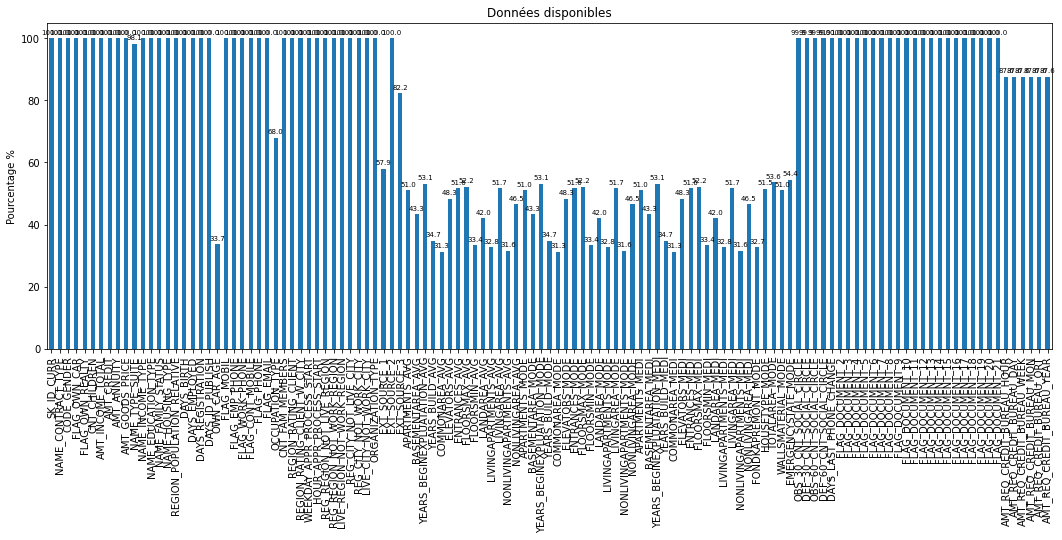

---------------------------
application_train 
 shape: (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
columns with first values is SK_ID_CURR and columns with last value is AMT_REQ_CREDIT_BUREAU_YEAR
There is 75.60405809287056 percent of values available in the Dataframe, available data above 0 percent have been kept


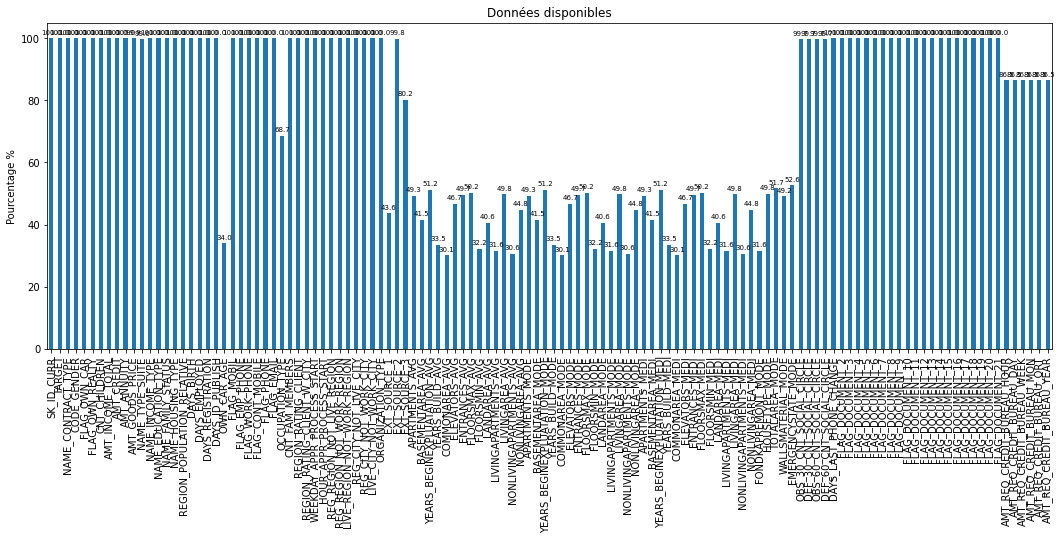

---------------------------
bureau 
 shape: (1716428, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
columns with first values is SK_ID_CURR and columns with last 

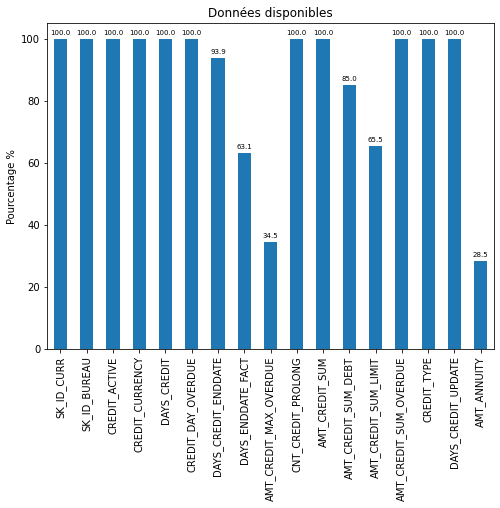

---------------------------
bureau_balance 
 shape: (27299925, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
columns with first values is SK_ID_BUREAU and columns with last value is STATUS
There is 100.0 percent of values available in the Dataframe, available data above 0 percent have been kept


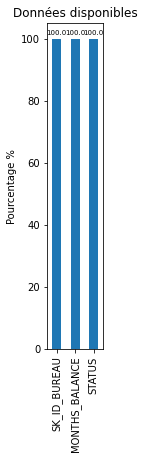

---------------------------
credit_card_balance 
 shape: (3840312, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  floa

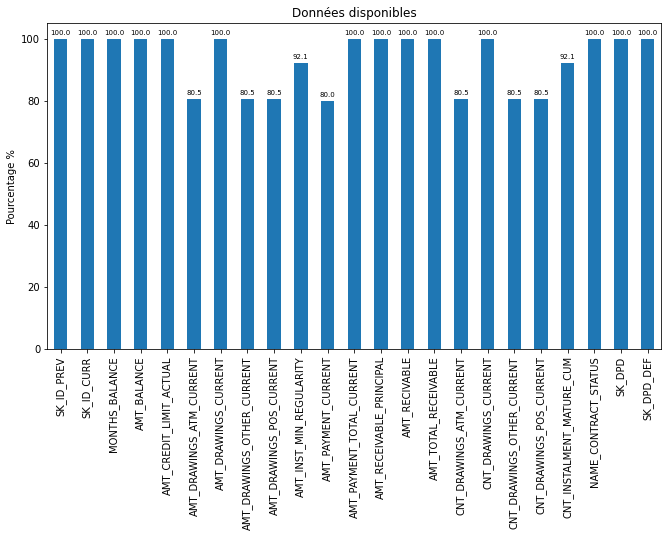

---------------------------
HomeCredit_columns_description 
 shape: (219, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      111 non-null    object
 5   Unnamed: 5   68 non-null     object
 6   Unnamed: 6   54 non-null     object
 7   Unnamed: 7   49 non-null     object
 8   Unnamed: 8   49 non-null     object
 9   Unnamed: 9   48 non-null     object
 10  Unnamed: 10  48 non-null     object
 11  Unnamed: 11  48 non-null     object
 12  Unnamed: 12  47 non-null     object
 13  Unnamed: 13  47 non-null     object
 14  Unnamed: 14  47 non-null     object
dtypes: int64(1), object(14)
memory usage: 25.8+ KB
columns with first values is Index and columns with last value is Un

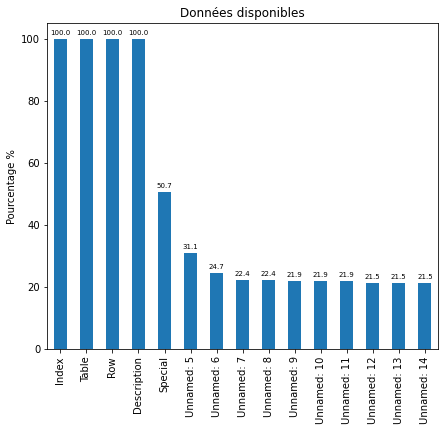

---------------------------
installments_payments 
 shape: (13605401, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
columns with first values is SK_ID_PREV and columns with last value is AMT_PAYMENT
There is 99.99466204634469 percent of values available in the Dataframe, available data above 0 percent have been kept


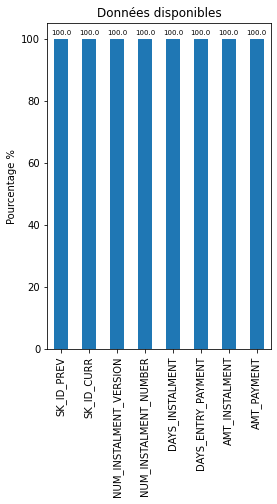

---------------------------
POS_CASH_balance 
 shape: (10001358, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
columns with first values is SK_ID_PREV and columns with last value is SK_DPD_DEF
There is 99.93481135261831 percent of values available in the Dataframe, available data above 0 percent have been kept


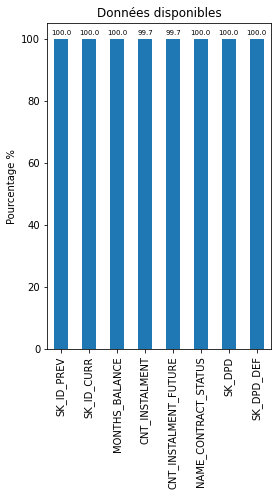

---------------------------
previous_application 
 shape: (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1

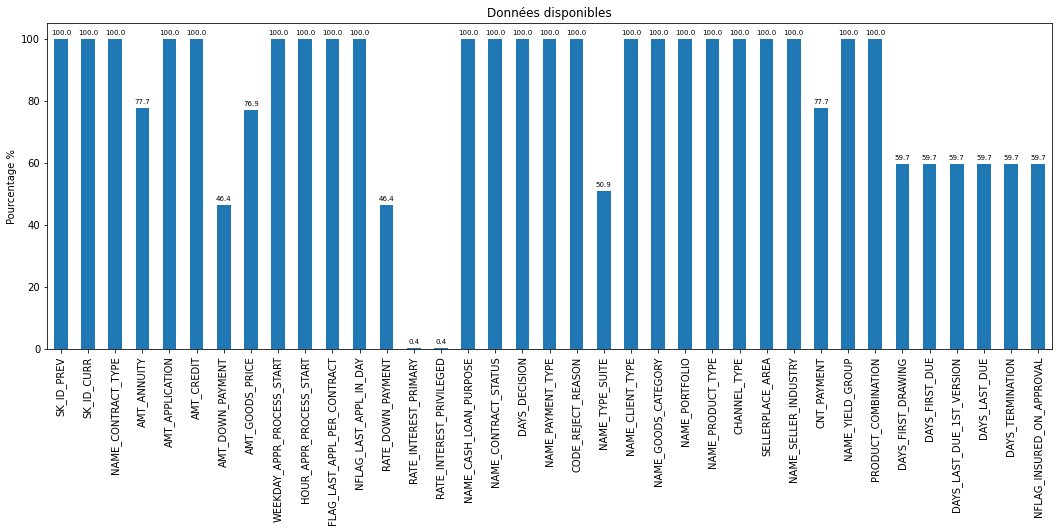

---------------------------
sample_submission 
 shape: (48744, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB
columns with first values is SK_ID_CURR and columns with last value is TARGET
There is 100.0 percent of values available in the Dataframe, available data above 0 percent have been kept


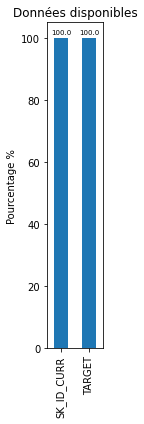

---------------------------


In [16]:
for file in list_csv_files:
    data = pd.read_csv(f'data_client_risk\\{file}', sep=',')
    data.name = os.path.splitext(file)[0]
    print(f'{data.name} \n shape: {data.shape}')
    data.info()
    columnsDataAvailable(data, 0)
    print('---------------------------')

--> let's try to evaluate unique columns data in our 8 files of data (without submissions and descriptions of data)

In [4]:
update_list_csv_files = [i for i in list_csv_files if i not in ['HomeCredit_columns_description.csv', 'sample_submission.csv']]
unique_columns = set()
for file in update_list_csv_files:
    data = pd.read_csv(f'data_client_risk\\{file}', sep=',')
    unique_columns.update(data.columns)
print(f'Il y a {len(unique_columns)} colonnes différentes dans toutes nos données')

Il y a 195 colonnes différentes dans toutes nos données


### **Evaluation of our first main file 'Train'**

In [5]:
df_train = pd.read_csv('data_client_risk\\application_train.csv', sep=',')
df_train.info()
df_train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

--> We can first underline our target which is binary:<br/>
    - 0, client with no loan payment difficulties<br/>
    - 1, client with loan payment difficulties

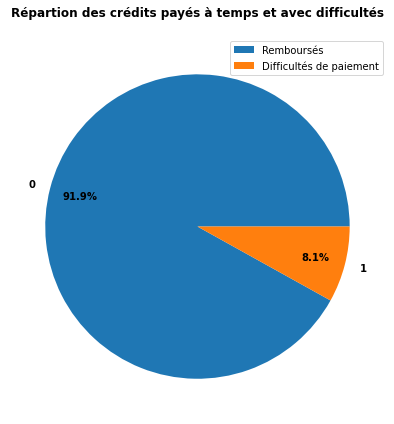

In [6]:
figure0 = plt.figure(figsize=(10,7), facecolor='w')
plt.title('Répartion des crédits payés à temps et avec difficultés', fontweight='bold', pad=20)
plt.axis('off')
x = df_train['TARGET'].value_counts()
expl = [0 if i/x.sum() > 0.02 else 0.8 for i in x]
plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        explode=expl, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.legend(['Remboursés', 'Difficultés de paiement'])
plt.show()

--> There is only 8% of the data that are concerning loan payment difficulties against 92% of loan refunded...<br/>
--> We have an imbalanced class problem

Function taken from Kaggle kernel --> https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction <br/>
Evaluate clearly numbers of columns with missing values

In [7]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(df_train).head(15)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


#### Quantitative variables: Evaluation of numeric variables correlation with target

In [9]:
df_correlation = df_train.corr()
df_correlation['TARGET'].sort_values(ascending=False).head(20)

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
Name: TARGET, dtype: float64

--> In a first appraoch we can consider the most linear correlation with the target for first features <br/>

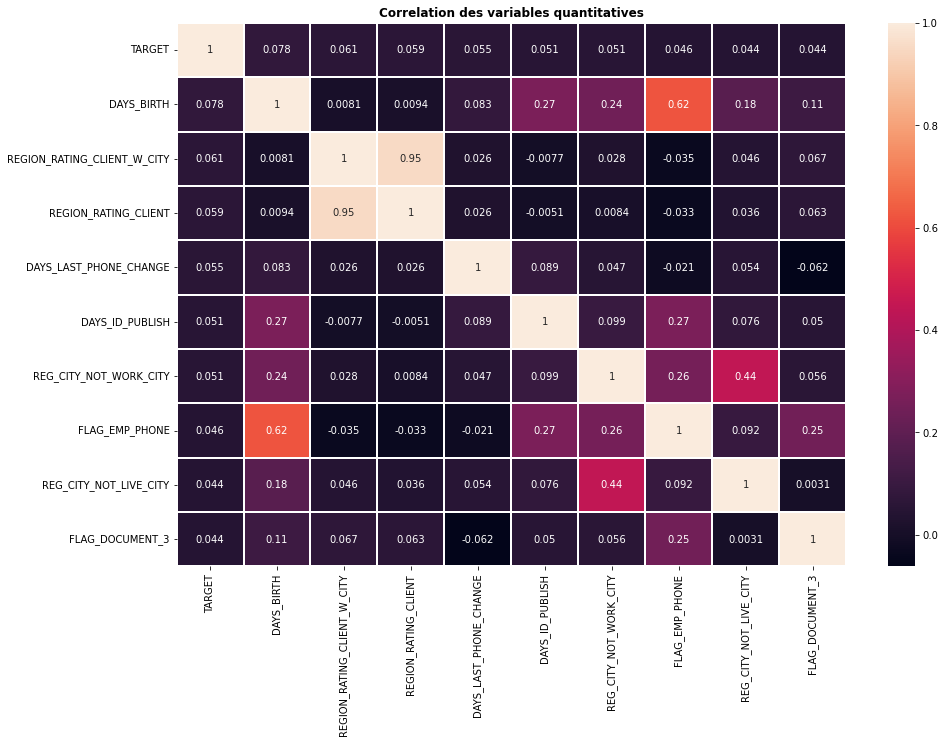

In [10]:
figure1 = plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size': 10})
plt.title(f'Correlation des variables quantitatives',fontweight = 'bold')
sns.heatmap(df_correlation.sort_values(by='TARGET', axis=1, ascending=False).sort_values(by='TARGET', axis=0, ascending=False).head(10).iloc[:,0:10]
            ,annot= True, linewidths= 0.3)
#plt.savefig('Correaltion_avec_les_cibles.jpg',dpi = 300,bbox_inches = 'tight')
plt.show()

--> This is not very easy here, all 10 first variables are under 0.1 of linear corelation <br/>
--> let's try to visualize some things regarding DAYS_BIRTH (must be divided by -365 to have the current age in years)

In [11]:
df_train['YEARS_BIRTH'] = df_train['DAYS_BIRTH']/(-365)

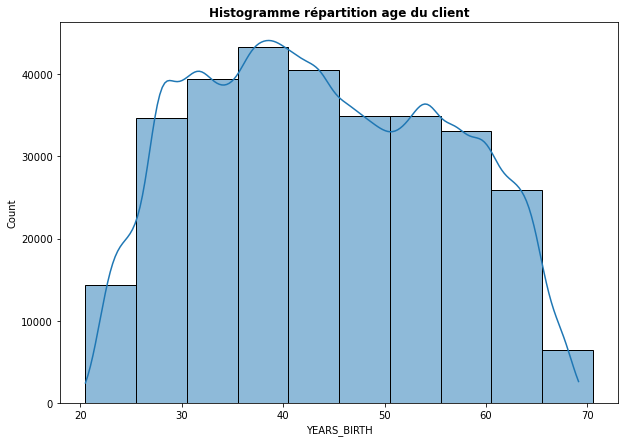

In [12]:
figure2 = plt.figure(figsize=(10,7))
plt.title('Histogramme répartition age du client', fontweight='bold')
sns.histplot(x=df_train['YEARS_BIRTH'], binwidth=5, kde=True)
plt.show()

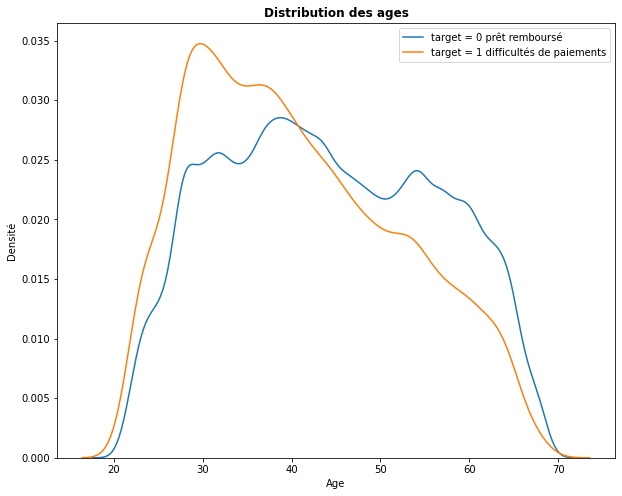

In [13]:
plt.figure(figsize = (10, 8))
plt.title('Distribution des ages', fontweight='bold')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'YEARS_BIRTH'], label = 'target = 0 prêt remboursé')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'YEARS_BIRTH'], label = 'target = 1 difficultés de paiements')
plt.xlabel('Age')
plt.ylabel('Densité')
plt.legend()
plt.show()

In [14]:
df_test_year = df_train[['TARGET', 'YEARS_BIRTH']].copy()
df_test_year['YEAR_RANGE'] = pd.cut(df_test_year['YEARS_BIRTH'], bins = range(20,75,5))
groupby_age = df_test_year.groupby('YEAR_RANGE').mean()

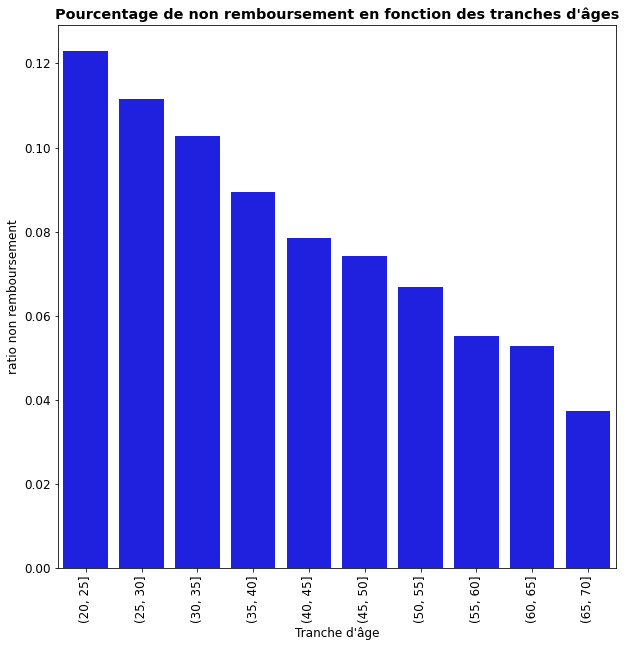

In [15]:
figure3 = plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 12})
plt.title("Pourcentage de non remboursement en fonction des tranches d'âges", fontweight='bold')
sns.barplot(x=groupby_age.index, y=groupby_age['TARGET'], color='b')
plt.xticks(rotation = 90)
plt.xlabel("Tranche d'âge")
plt.ylabel("ratio non remboursement")
plt.show()

--> File exploration is very difficult (especially without job knowledge...) <br/>
--> Let's use a kaggle kernel to obtain datas cleaned and preprocess to pass to the modeling part!

## **II) Kernel Kaggle for cleaning and preprocessing**

We will use the kernel available here: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features <br/>
--> Kernel will be used to obtain feature data with target. <br/>
--> Part concerning the modeling will not be applied
--> We will get csv from features+target in the end

### **Kernel informations** <br/>
 HOME CREDIT DEFAULT RISK COMPETITION
 Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
 Little feature selection is done and overfitting might be a problem since many features are related.
 The following key ideas were used:
 - Divide or subtract important features to get rates (like annuity and income)
 - In Bureau Data: create specific features for Active credits and Closed credits
 - In Previous Applications: create specific features for Approved and Refused applications
 - Modularity: one function for each table (except bureau_balance and application_test)
 - One-hot encoding for categorical features
 All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
 You can use LightGBM with KFold or Stratified KFold.

 Update 16/06/2018:
 - Added Payment Rate feature
 - Removed index from features
 - Use standard KFold CV (not stratified)

### **Define functions from the kernel that we will use**

In [18]:
# preprocessing one_hot_encoding (with get_dummies)
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# prepocessing on the files train and test
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(f'data_client_risk\\application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(f'data_client_risk\\application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    # gc is here to optimized memory management
    gc.collect()
    return df

# preprocessing on the files bureau + bureau_balance
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(f'data_client_risk\\bureau.csv', nrows = num_rows)
    bb = pd.read_csv(f'data_client_risk\\bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# preprocessing on file Previous application
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(f'data_client_risk\\previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# preprocessing on the file POS_CASH_balance
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(f'data_client_risk\\POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

#preprocessing on the file Installement_payments
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(f'data_client_risk\\installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

#preprocessing on the file credit_card_balance
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(f'data_client_risk\\credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

### **Create a function to preprocess all the file and return a csv file with features and target**

In [20]:
def preprocess_data_home_credit_default(file_name, debug = False):
    '''Function to preprocess and aggregate in one df features+target of clients and saving in the current working directory a csv file
    - debug --> otpion to test our function with only a fraction of rows in the data
    - file_name --> must be an str, name of the final csv file return by the function'''
    
    init_time = time.time()
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print(f'Main df init shape: {df.shape}')
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    print(f'Main df final shape: {df.shape}')
    df.to_csv(f'{file_name}.csv')
    print(f'Function executed in : {time.time() - init_time} s')    

### **Using our function to create a csv with features and target data**

In [21]:
preprocess_data_home_credit_default('Home_credit_risk_data_modeling')

Train samples: 307511, test samples: 48744
Main df init shape: (356251, 248)
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)
Main df final shape: (356251, 798)
Function executed in : 292.521607875824 s


## **III) Data prep, split, imputation, oversampling and undersampling**

### **Examinating our new csv file (and extracting train and test sample)**

In [2]:
df_data_mod = pd.read_csv('Home_credit_risk_data_modeling.csv', index_col=0)
df_data_mod.info()
columns_no_nan = [i for i in df_data_mod.columns if df_data_mod[i].isnull().sum() == 0]
df_train_sample = df_data_mod.loc[~(df_data_mod['TARGET'].isnull())]
df_test_sample = df_data_mod.loc[df_data_mod['TARGET'].isnull()]
del df_data_mod
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 798 entries, index to CC_COUNT
dtypes: float64(622), int64(176)
memory usage: 2.1 GB


0

### **Imputation, Split, Normalisation and  Oversampling / Undersampling of our train data**

#### Imputation

In [4]:
df_train_sample

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZ

In [3]:
# Defining X and y with train data
X = df_train_sample.drop(columns = ['TARGET','SK_ID_CURR','index']).copy()
y = df_train_sample['TARGET'].copy()
# Checking inf
np.isinf(X).values.sum()

20

In [4]:
# Replace inf values by max() and min() values
col_min_max = {np.inf: X[np.isfinite(X)].max(),    # column-wise max
              -np.inf: X[np.isfinite(X)].min()}    # column-wise min

X = X.replace({col: col_min_max for col in X.columns})
np.isinf(X).values.sum()

0

In [ ]:
# Checking NaN values

In [7]:
X.isna().sum()

CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
CNT_CHILDREN                             0
AMT_INCOME_TOTAL                         0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     220602
CC_NAME_CONTRACT_STATUS_nan_MEAN    220602
CC_NAME_CONTRACT_STATUS_nan_SUM     220602
CC_NAME_CONTRACT_STATUS_nan_VAR     221234
CC_COUNT                            220602
Length: 795, dtype: int64

In [5]:
# features detection before imputation, numerical continue or numerical discrete
def list_features_att(df):
    '''Function to attribute to columns of a dataframe a category into a several list
    it returns two lists.
    --> Numerical: num_list
    --> discrete_numerical: num_dis_list'''
    
    num_list = list()
    num_dis_list = list()
    for name in df.columns:
        if df[name].nunique() < 10:
            num_dis_list.append(name)
        else:
            num_list.append(name)
    return num_list, num_dis_list

In [6]:
numerical_cont_list, numerical_disc_list = list_features_att(X)

In [7]:
time_init = time.time()
#imputation on numeric continue columns with 'mean' strategy
X[numerical_cont_list] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cont_list])
#imputation on  discrete numeric columns with 'most_frequent' strategy
X[numerical_disc_list] = SimpleImputer(strategy='most_frequent').fit_transform(X[numerical_disc_list])
print (f'time for imputation: {time.time() - time_init:.2f}')

time for imputation: 50.88


#### Split and Normalization

In [11]:
time_init = time.time()
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=4)
# Normalization of the imput data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
print (f'Time for Spliting and Normalize: {time.time() - time_init:.2f}')

Time for Spliting and Normalize: 10.02


#### OverSampling and UnderSampling train dataset to balance our classes (imbalanced class problem)

Time for Oversampling and Undersampling: 46.99


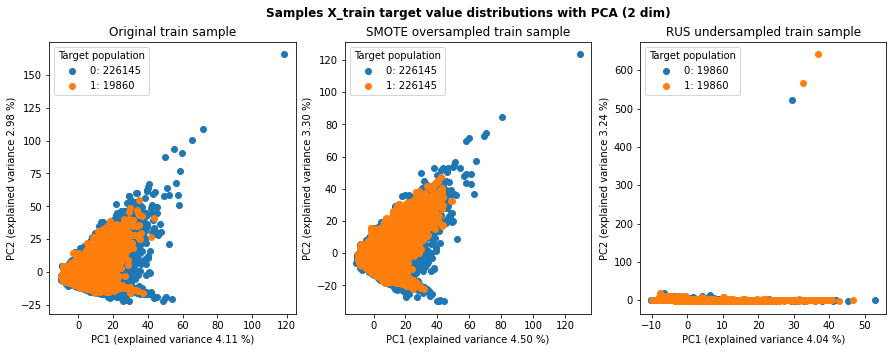

In [12]:
time_init = time.time()
# Oversampling --> SMOTE
oversampling = SMOTE(random_state = 4)
X_train_smote, y_train_smote = oversampling.fit_resample(X_train, y_train)
# Undersampling --> RUS
undersampling = RandomUnderSampler(random_state = 4)
X_train_rus, y_train_rus = undersampling.fit_resample(X_train, y_train)
print(f'Time for Oversampling and Undersampling: {time.time() - time_init:.2f}')
# Visualization of sampling (using PCA)
figure_samples = plt.figure(figsize=(15, 5))
plt.axis('off')
plt.title('Samples X_train target value distributions with PCA (2 dim)', fontweight='bold', pad=25)
                            
# X_train sample
figure_samples.add_subplot(1,3,1)
plt.title('Original train sample')
pca = decomposition.PCA(n_components=2, random_state=4)
pca.fit(X_train)
data_projected = pca.transform(X_train)

for val in y_train.unique():
    row_idx = np.where(y_train == val)[0]
    plt.scatter(data_projected[row_idx, 0], data_projected[row_idx, 1], 
                label=f'{str(int(val))}: {Counter(y_train[y_train.index[row_idx]])[val]}')

plt.xlabel(f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
plt.ylabel(f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
plt.legend(title='Target population')
                            
# X_train oversampling SMOTE
figure_samples.add_subplot(1,3,2)
plt.title('SMOTE oversampled train sample')
pca = decomposition.PCA(n_components=2, random_state=4)
pca.fit(X_train_smote)
data_projected = pca.transform(X_train_smote)

for val in y_train_smote.unique():
    row_idx = np.where(y_train_smote == val)[0]
    plt.scatter(data_projected[row_idx, 0], data_projected[row_idx, 1], 
                label=f'{str(int(val))}: {Counter(y_train_smote[y_train_smote.index[row_idx]])[val]}')

plt.xlabel(f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
plt.ylabel(f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
plt.legend(title='Target population')

# X_train undersampling RUS
figure_samples.add_subplot(1,3,3)
plt.title('RUS undersampled train sample')
pca = decomposition.PCA(n_components=2, random_state=4)
pca.fit(X_train_rus)
data_projected = pca.transform(X_train_rus)

for val in y_train_rus.unique():
    row_idx = np.where(y_train_rus == val)[0]
    plt.scatter(data_projected[row_idx, 0], data_projected[row_idx, 1], 
                label=f'{str(int(val))}: {Counter(y_train_rus[y_train_rus.index[row_idx]])[val]}')

plt.xlabel(f'PC1 (explained variance {pca.explained_variance_ratio_[0]*100:.2f} %)')
plt.ylabel(f'PC2 (explained variance {pca.explained_variance_ratio_[1]*100:.2f} %)')
plt.legend(title='Target population')

plt.show()

## **IV) Models tests with SMOTE data, RUS data**

### **Model selection with RUS data (less data)**

#### Dummy classifier for baseline

In [13]:
# Dummy classifier to compare with our first model 
dummy_const_mod = DummyClassifier(strategy='constant', constant=0)
time_init = time.time()
dummy_const_mod.fit(X_train_rus, y_train_rus)
time_end = time.time()
y_pred_pro_dumm_const_1 = dummy_const_mod.predict_proba(X_test)[:,1]
y_pred_dumm_const_1 = dummy_const_mod.predict(X_test)

In [14]:
# Create df for results
summary_result = list()
summary_result.append({'model':'Dummy_constant=1', 'Score AUC':roc_auc_score(y_test, y_pred_pro_dumm_const_1), 
                       'F1_score': f1_score(y_test, y_pred_dumm_const_1), 'F2_score': fbeta_score(y_test, y_pred_dumm_const_1, beta=2),
                       'Train Time(s)':time_end - time_init, 'Comment': 'RUS train data'})
df_summary_result1 = pd.DataFrame(summary_result)
df_summary_result1

,model,Score AUC,F1_score,F2_score,Train Time(s),Comment
0,Dummy_constant=1,0.5,0.0,0.0,0.0,RUS train data


#### GridSearchCV with Logistic Regression

In [18]:
# prameters dict
models_params = {'LogisticRegression':{'model':linear_model.LogisticRegression(random_state=4, max_iter=800),
                                       'params':{'C':np.logspace(2,3,3)}}}
# grid search
scores_CV5 = list()
for model_name,mp in models_params.items():
    gride_mod = GridSearchCV(mp['model'],mp['params'], cv = 5, scoring='roc_auc')
    gride_mod.fit(X_train_rus,y_train_rus)
    scores_CV5.append({'model':model_name, 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':'RUS train data'})
    
df_scores_CV5_1 = pd.DataFrame(scores_CV5)
df_scores_CV5_1

C:\Users\ysene\anaconda3\envs\OpenClassRooms2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ysene\anaconda3\envs\OpenClassRooms2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

,model,best_score AUC,best parameters,Best model,Refit Time(s),Comment
0,LogisticRegression,0.767817,{'C': 316.22776601683796},"LogisticRegression(C=316.22776601683796, max_i...",33.368571,RUS train data


--> Logistic regression don't seemed to converge even by raising the number of iteration... <br/>
--> let's keep this result

#### GridSearchCV with Support Vector Machine classifier

In [ ]:
# prameters dict
models_params = {'SVC':{'model':SVC(random_state=4),
                                       'params':{'C':np.logspace(2,3,3)}}}
# grid search
scores_CV5 = list()
for model_name,mp in models_params.items():
    gride_mod = GridSearchCV(mp['model'],mp['params'], cv = 5, scoring='roc_auc')
    gride_mod.fit(X_train_rus,y_train_rus)
    scores_CV5.append({'model':model_name, 'best_score AUC':gride_mod.best_score_, 'best parameters':gride_mod.best_params_,
                       'Best model':gride_mod.best_estimator_,'Refit Time(s)':gride_mod.refit_time_, 'Comment':'RUS train data'})
    
df_scores_CV5_1 = df_scores_CV5_1.append(scores_CV5)
df_scores_CV5_1